# Practical session n°6

Notions:
- Generative Adversarial Networks
- Mode Collapse
- Wasserstein GAN
- Conditional GAN


Duration: 2 h

With this notebook, we aim to characterize a distribution in an image domain, rather than at the pixel level.

In high dimensions, especially on real images, the joint distribution is not modelable. It is not feasible to seek its density. However, we can attempt to sample from this distribution by relying on an existing set of images.
We will start by doing this without worrying about the conditional aspect:
in **Exercise 1**, the goal is to build a **generative model** that samples a domain of synthetic images.

Most recent generative models are primarily constructed from deep neural networks. In the field of image generation, one of the main approaches is based on **GANs** (Generative Adversarial Networks). **Exercise 1** illustrates this approach in its simplest version, while **Exercise 2** presents some variations.
Finally, **Exercise 3** gives us the opportunity to revisit the conditional aspect. The GAN approach is modified to sample from an implicit conditional distribution.

**Exercise 1** A first GAN.



The principle of GAN is simple. We have:
- A random vector $Z$, sampled from a simple distribution, for example, a centered reduced Gaussian vector.
- A generative network $G_\theta$ ($\theta$ represents the generator's weights) that generates an image $G_\theta(Z)$.
- A discriminator network $D_\rho$ ($\rho$ represents the discriminator's weights), ending with a sigmoid function that classifies an image $x$ as "real" ($D_\rho(x) > 0.5$) or "fake" ($D_\rho(x) < 0.5$).

In the following, we omit the notations $\rho$ and $\theta$.

The algorithm consists of training $G$ and $D$ on adversarial tasks:
- $D_\rho$ is trained to distinguish images from the dataset ($x^{(i)}$) from images generated by $G_\theta$ (denoted as $G(z^{(i)})$). In the [original GAN paper](https://arxiv.org/abs/1406.2661), the authors use cross-entropy as the cost function. For a pair of two images, one fake and the other real, the cost is written as:
  $$  - {\bigg [} \ln(D(x^{(i)})) + \ln(1 - D(G(z^{(i)})) {\bigg ]}$$

- $G_\theta$ is trained to "fool" the discriminator with the adversarial cost function:
  $$  \ln(1 - D(G(z^{(i)}))) $$

A theoretical analysis of the problem is covered in the supplementary exercise sheet. Here, we implement the algorithm on synthetic images.


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import time
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, models, transforms

In [ ]:
! git clone https://github.com/nanopiero/ML_S5_etudiants


Cloning into 'ML_S5_etudiants'...
remote: Enumerating objects: 137, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 137 (delta 10), reused 5 (delta 5), pack-reused 121 (from 1)
Receiving objects: 100% (137/137), 2.58 MiB | 21.15 MiB/s, done.
Resolving deltas: 100% (43/43), done.


In [ ]:
! cp ML_S5_etudiants/practicals/P6/utils.py .

In [ ]:
from utils import gen_DCGAN, UNet, voir_batch2D

Let's first define an image generation problem. The following function samples the random image $X$ and the random vector $Z$:

In [ ]:
# Rectangle proportion in the image:
lambda_rec = 0.0

x, z = gen_DCGAN(6, lambda_rec=lambda_rec)

# Clean versions (individual cells)
fig1 = plt.figure(1, figsize=(36, 6))
voir_batch2D(x, 6, fig1, k=0, min_scale=0, max_scale=1)

fig3 = plt.figure(3, figsize=(36, 6))
voir_batch2D(z, 6, fig3, k=0, min_scale=0, max_scale=1)

**Q1** The vector $Z$ is an image. What type of network is suitable for $G$? Instantiate it.

In [ ]:
n_channels, n_classes, size = 1, 1, 8

netG = UNet(n_channels, n_classes, size).cuda()

**Q2** The Discriminator class is used to encode the discriminator. Instantiate it and use the *weight_init* function to initialize the network's weights. What type of network do you obtain in this way?

In [ ]:
ndf = 32
nc = 1


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

netD = Discriminator().cuda()
netD.apply(weights_init)

Let's now specify some training parameters (most of them are standard for GANs):

In [ ]:
# Fixing the seed (to reproduce results)
manualSeed = 1
import random
random.seed(manualSeed)
torch.manual_seed(manualSeed)

# Number of parallel processes:
workers = 2

# Image size
image_size = 64

# Number of channels
nc = 1

# Batch size
batch_size = 64

# Number of batches per epoch
num_batches = 200
num_epochs = 10

# Learning rate
lr = 0.0002

# Beta1 hyperparameter for Adam
beta1 = 0.5  # Sometimes simply 0.

# Cross-entropy
criterion = nn.BCELoss()

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [ ]:
# To observe how G(z) evolves with z fixed along the training:
_ , fixed_z = gen_DCGAN(batch_size, lambda_rec=lambda_rec)
fixed_z = fixed_z.cuda()

**Q3** Add comments to the following snippet. Why D_fake and D_fake2 are computed ? How could these variables be interpreted ?

In [ ]:
# Lists for stats
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")

for epoch in range(num_epochs):
    for i in range(num_batches):

        # Sampling X and Z
        x, z = gen_DCGAN(batch_size, lambda_rec=lambda_rec)

        # Real images
        x = x.cuda()

        # White noise
        z = z.cuda()

        # STEP 1: Discriminator optimization

        # Zeroing discriminator gradients
        netD.zero_grad()

        # Discrimination of real images
        D_real = netD(x).view(-1)

        # Gradients with respect to discriminator weights on the batch of real images
        label = torch.ones((batch_size,)).cuda()
        errD_real = criterion(D_real, label)
        errD_real.backward()

        # To calculate accuracy:
        D_real = D_real.mean().item()

        # Generated images
        fake = netG(z)

        # Discrimination of generated images
        # .detach() -> we do not calculate gradients with respect to netG weights
        # at this step
        D_fake = netD(fake.detach()).view(-1)

        # Gradients with respect to discriminator weights on the batch of generated images
        label.fill_(0.)
        errD_fake = criterion(D_fake, label)
        errD_fake.backward()

        # Overall loss:
        errD = errD_real + errD_fake

        # Update discriminator weights
        optimizerD.step()

        # To display D_fake
        D_fake = D_fake.mean().item()

        # STEP 2: Generator optimization
        netG.zero_grad()

        # Regeneration, but gradients calculation is maintained
        D_fake2 = netD(fake).view(-1)

        # Update generator weights
        label.fill_(1.)
        errG = criterion(D_fake2, label)
        errG.backward()

        # To display D_fake2
        D_fake2 = D_fake2.mean().item()
        optimizerG.step()

        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, num_batches,
                     errD.item(), errG.item(), D_real, D_fake, D_fake2))

        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Store generated images from "fixed_z" every hundred epochs
        if (iters % 100 == 0) or ((epoch == num_epochs - 1) and (i == num_batches - 1)):
            with torch.no_grad():
                fake = netG(fixed_z).detach().cpu()
            img_list.append(fake)
        iters += 1

**Q4** Plot the evolution of the cost functions for the generator and discriminator. Visualize the successive images. Comment.

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
for k, img in enumerate(img_list):
  plt.figure(k)
  print(len(img_list))
  voir_batch2D(img_list[k], 8, fig1, k=0, min_scale=0,max_scale=1)

**Q5** Give a qualitative and and quantitative analysis of the outputs of the generator after these few epochs.

In [ ]:
# Testing the Generator:
_ , z = gen_DCGAN(6, lambda_rec = lambda_rec)
z = z.cuda()
fake = netG.eval()(z).detach()

fig = plt.figure(1, figsize=(12, 4))
voir_batch2D(fake.cpu(), 14, fig1, k=0, min_scale=0,max_scale=1)

The training is not yet perfect (improvement could be achieved with more epochs), but the generator manages to sample images that are roughly close to the original images. It has started to reproduce intersections between cells. \
One could verify this quantitatively by comparing classical statistics (mean per pixel, standard deviation, etc.) or even spectral densities.

In [ ]:
import torch
import matplotlib.pyplot as plt

netG.eval()

# Assuming the following are defined: gen_DCGAN, netG, num_batches, batch_size, lambda_rec
num_epochs = 1  # For simplicity, only one epoch
real_image_avg = None
fake_image_avg = None
total_real_images = 0
total_fake_images = 0

for epoch in range(num_epochs):
    for i in range(num_batches):
      with torch.no_grad():
        # Generate real and latent inputs
        x, z = gen_DCGAN(batch_size, lambda_rec=lambda_rec)
        z = z.cuda()
        x = x.cuda()

        # Generate fake images
        fake = netG(z.detach())

        # Update pixel-wise averages
        if real_image_avg is None:
            real_image_avg = x.sum(dim=0)
            fake_image_avg = fake.sum(dim=0)
        else:
            real_image_avg += x.sum(dim=0)
            fake_image_avg += fake.sum(dim=0)

        # Accumulate counts
        total_real_images += x.shape[0]
        total_fake_images += fake.shape[0]

# Normalize to get pixel-wise averages
real_image_avg /= total_real_images
fake_image_avg /= total_fake_images

# Convert to CPU for plotting
real_image_avg = real_image_avg.cpu().detach()
fake_image_avg = fake_image_avg.cpu().detach()

# Plot the average real and fake images
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(real_image_avg.permute(1, 2, 0).numpy())
plt.title("Average Real Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(fake_image_avg.permute(1, 2, 0).numpy())
plt.title("Average Fake Image")
plt.axis("off")

plt.tight_layout()
plt.show()

**Q6** Restart training with additional rectangles on the image. Visualize and comment on the results.

In [ ]:
# Rectangle proportion in the image :
lambda_rec = 0.00025

x , z = gen_DCGAN(6, lambda_rec = lambda_rec)

# Propre versions (only cells)
fig1 = plt.figure(1, figsize=(36, 6))
voir_batch2D(x, 6, fig1, k=0, min_scale=0,max_scale=1)


fig3 = plt.figure(3, figsize=(36, 6))
voir_batch2D(z, 6, fig3, k=0, min_scale=0,max_scale=1)

In [ ]:
manualSeed = 1
num_epochs = 20
random.seed(manualSeed)
torch.manual_seed(manualSeed)

netD = Discriminator().cuda()
netD.apply(weights_init)
netG = UNet(n_channels, n_classes, size).cuda()
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

# Lists for stats
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")

for epoch in range(num_epochs):
    for i in range(num_batches):
        # Sampling X and Z
        x, z = gen_DCGAN(batch_size, lambda_rec=lambda_rec)

        # Real images
        x = x.cuda()

        # White noise
        z = z.cuda()

        # STEP 1: Discriminator optimization

        # Zeroing discriminator gradients
        netD.zero_grad()

        # Discrimination of real images
        D_real = netD(x).view(-1)

        # Gradients with respect to discriminator weights on the batch of real images
        label = torch.ones((batch_size,)).cuda()
        errD_real = criterion(D_real, label)
        errD_real.backward()

        D_real = D_real.mean().item()

        fake = netG(z.cuda())

        D_fake = netD(fake.detach()).view(-1)

        label.fill_(0.)
        errD_fake = criterion(D_fake, label)
        errD_fake.backward()

        errD = errD_real + errD_fake

        optimizerD.step()

        D_fake = D_fake.mean().item()

        # STEP 2: Generator optimization
        netG.zero_grad()
        label.fill_(1.)

        D_fake2 = netD(fake).view(-1)

        errG = criterion(D_fake2, label)
        errG.backward()

        D_fake2 = D_fake2.mean().item()
        optimizerG.step()

        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, num_batches,
                     errD.item(), errG.item(), D_real, D_fake, D_fake2))

        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Store generated images from "fixed_z" every hundred epochs
        if (iters % 100 == 0) or ((epoch == num_epochs - 1) and (i == num_batches - 1)):
            with torch.no_grad():
                fake = netG(fixed_z.cuda()).detach().cpu()
            img_list.append(fake)
        iters += 1

41


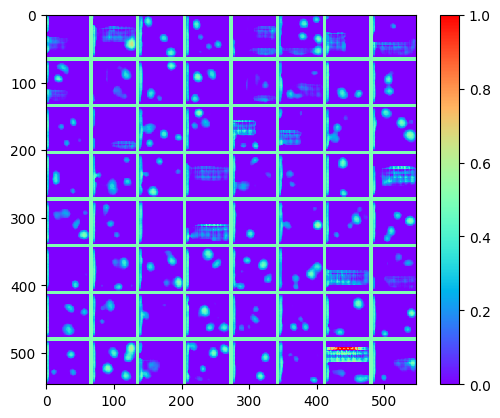

In [ ]:
print(len(img_list))
voir_batch2D(img_list[-1], 8, fig1, k=0, min_scale=0,max_scale=1)

On the generated images, a clear issue arises: the same rectangles reappear in multiple images of the batch. This problem is called 'mode collapse'. It often occurs with GANs and can complicate their training.

**Exercise n°2** Wasserstein-GANs.

To facilitate the convergence of GANs, several approaches have been explored. In particular:
- Giving the discriminator more time to converge at each step.
- use different cost functions
- Keep the Lipschitzianity of the discriminator. This option takes its root in an interesting theoretical approach (see the supplementary exercise sheet). It can be done:

  * by constraining the weights of the discriminator to remain within a given interval (see the paper introducing WGANs [(Wasserstein-GANs)](https://arxiv.org/abs/1701.07875).

  * by [gradient penalization](https://arxiv.org/pdf/1704.00028.pdf)   

**Q2** In the following cells, these four ideas are implemented. Say where.

In [ ]:
nc = 1
ndf = 32

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
def calculate_gradient_penalty(model, real_images, fake_images):
    alpha = torch.randn((real_images.size(0), 1, 1, 1)).cuda()
    interpolates = (alpha * real_images + ((1 - alpha) * fake_images)).requires_grad_(True)

    model_interpolates = model(interpolates)
    grad_outputs = torch.ones(model_interpolates.size(), requires_grad=False).cuda()

    # Get gradient w.r.t. interpolates
    gradients = torch.autograd.grad(
        outputs=model_interpolates,
        inputs=interpolates,
        grad_outputs=grad_outputs,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = torch.mean((gradients.norm(2, dim=1) - 1) ** 2)
    return gradient_penalty

In [ ]:
n_channels, n_classes,size = 1, 1, 16
netG = UNet(n_channels, n_classes, size).cuda()

netD = Discriminator()
netD.apply(weights_init)
netD = netD.cuda()

In [ ]:
# Proportion of rectangle in the image:
lambda_rec = 0.00025

# Fixing the seed for reproducibility:
manualSeed = 1
torch.manual_seed(manualSeed)

# Number of parallel processes:
workers = 2

# Image size:
image_size = 64

# Number of channels:
nc = 1

# Batch size:
batch_size = 64

# Number of batches per epoch (for the generator):
num_batches_generator = 200
num_epochs = 30

# Learning rate:
lr = 0.0001

# Beta1 hyperparameter for Adam:
beta1 = 0.  # In the paper introducing gradient penalty

# Number of GPUs:
ngpu = 1

# Cross-entropy & label conventions:
criterion = nn.BCELoss()

# Gradient penalty (gp) or classic WGAN:
add_gp = True

# Setup Adam optimizers for both G and D:
# If gradient penalty:
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))
# If not:
# optimizerD = optim.RMSprop(netD.parameters(), lr=lr)
# optimizerG = optim.RMSprop(netG.parameters(), lr=lr)

# Schedulers:
step_size = 31
gamma = 0.2
schedulerD = torch.optim.lr_scheduler.StepLR(optimizerD, step_size=step_size, gamma=gamma)
schedulerG = torch.optim.lr_scheduler.StepLR(optimizerG, step_size=step_size, gamma=gamma)

In [ ]:
# To observe how G(z) evolves with fixed z during training:
_ ,  fixed_z = gen_DCGAN(batch_size, lambda_rec=lambda_rec)
fixed_z = fixed_z.cuda()

In [ ]:
img_list = []
G_losses = []
D_losses = []

n_critic = 5
clip = 0.01

print("Starting Training Loop...")

for epoch in range(num_epochs):
    for i in range(num_batches_generator):
        netG.train()
        for j in range(n_critic):
            x , z = gen_DCGAN(batch_size, lambda_rec=lambda_rec)
            ############################
            # (1) Update netD network:
            ###########################
            netD.zero_grad()
            real = x.cuda()
            output_real = netD(real)
            fake = netG(z.cuda())
            output_fake = netD(fake.detach())

            if add_gp:
                gradient_penalty = calculate_gradient_penalty(netD,
                                                   real.data, fake.data)
                errD = output_fake.mean() - output_real.mean() + 10 * gradient_penalty

            else :
                errD = output_fake.mean() - output_real.mean()

            errD.backward()

            optimizerD.step()

            if not add_gp:
                for p in netD.parameters():
                    p.data.clamp_(-clip, clip)

        ############################
        # (2) Update netG network:
        ###########################
        netG.zero_grad()

        fake = netG(z.cuda())
        output_fake = netD(fake).view(-1)

        errG = -output_fake.mean()

        errG.backward()

        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f'
                  % (epoch+1, num_epochs, i, num_batches_generator,
                     errD.item()))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise

    with torch.no_grad():
        netG.eval()
        fake = netG(fixed_z.cuda()).detach().cpu()
#            img_list.append(vutils.make_grid(fake, padding=2, normalize=False))
    img_list.append(fake)


    schedulerD.step()
    schedulerG.step()


**Q3** Can we still observe mode collapse in these images?

In [ ]:
plt.figure(figsize=(15,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")

plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
fig1 = plt.figure(1)
print(len(img_list))
voir_batch2D(img_list[-5], 8, fig1, k=0, min_scale=0,max_scale=1)



Indeed, the outputs of the generator, while not yet perfect, show no signs of mode collapse.

**Q4** Let's finally see the results of training over several hours. Load the UNet trained for 600 epochs (*netG_600.pt*) and visualize the generated images.

In [ ]:
! pip install huggingface_hub
from huggingface_hub import hf_hub_download
model_hf_name = "P6_Ex2_netG_600ep_WGP_lr0001.pt"
path_netG = hf_hub_download(repo_id="nanopiero/models_ML_S5_P6", filename=model_hf_name)

In [ ]:
n_channels, n_classes,size = 1, 1, 16
netG_600ep = UNet(n_channels, n_classes, size).cuda()
netG_600ep.load_state_dict(torch.load(path_netG)['model_state_dict'])
netG_600ep = netG_600ep.cuda()

<ipython-input-29-b713d921c9c0>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  netG_600ep.load_state_dict(torch.load(path_netG)['model_state_dict'])


In [ ]:
netG_600ep.eval()
x , z = gen_DCGAN(6, lambda_rec = lambda_rec)

# Generate fake image batch with G


real_and_fakes = [x]
n = 4
for i in range(n):
    _ ,  z = gen_DCGAN(6, lambda_rec = lambda_rec)
    z = z.cuda()
    with torch.no_grad():
        fake = netG_600ep(z).cpu()
    real_and_fakes.append(fake)

real_and_fakes = torch.cat(real_and_fakes,dim=0)
fig1 = plt.figure(4, figsize=(36, 6))
voir_batch2D(real_and_fakes, 6, fig1, k=0, min_scale=0, max_scale=1)

**Exercice n°3** A conditional GAN.  




In this exercise, the goal is to implement a conditional Wasserstein-GAN. Once again, theoretical aspects are set aside; the objective is solely to construct the training loop.
The context is as follows: we have a set of images representing a domain 𝒟.
The traditional GAN generates new images from 𝒟. In this exercise, we will generate images compatible with a given list of pixel values a priori.

The following cells allow visualization of the available dataset.


In [ ]:
from utils import gen_condDCGAN, UNet, voir_batch2D

In [ ]:
# Proportion of pixels preserved in yi:
obs_density = 0.005

x, y, z = gen_condDCGAN(6, obs_density)

# Full images xi
fig1 = plt.figure(1, figsize=(36, 6))
voir_batch2D(x, 6, fig1, k=0, min_scale=0, max_scale=1)

# Fragmentary images yi: a few pixels randomly sampled from xi
fig2 = plt.figure(2, figsize=(36, 6))
voir_batch2D(y, 6, fig2, k=0, min_scale=-0.2, max_scale=1)

# zi: sample from a centered reduced Gaussian vector
fig3 = plt.figure(3, figsize=(36, 6))
voir_batch2D(z, 6, fig3, k=0, min_scale=0, max_scale=1)

**Q1** Drawing inspiration from the previous exercise, complete the training loop and run it for ten epochs:

In [ ]:
# SGD Setup
batch_size = 128
num_batches_generator = 200
num_epochs = 10

# nn setup
n_channels = 2
n_classes = 1
size = 16
netG = UNet(n_channels, n_classes, size).cuda()

nc = 2
ndf = 32

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
        )

    def forward(self, input):
        return self.main(input)


netD = Discriminator().cuda()

# Optimizer Parameters
lr = 0.0005
beta1 = 0.  # SGD momentum
# optimizers
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [ ]:
# To keep track of generated images from a fixed sample of $z_i$:
fixed_x, fixed_y, fixed_z = gen_condDCGAN(8, p=obs_density)

# Fixed input for the generator:
fixed_yz = torch.cat((fixed_y, fixed_z), dim=1).cuda()

# Lists
img_list = []
G_losses = []
D_losses = []

# Other hyperparameters
n_critic = 1
clip = 0.01
add_gp = True

In [ ]:
criterion = nn.BCELoss()
print("Starting Training Loop...")

# For each epoch
for epoch in range(num_epochs):

    netG.train()
    # For each batch in the dataloader
    for i in range(num_batches_generator):

        # Here, we perform multiple (n_critic) optimization steps for the discriminator.
        for j in range(n_critic):

            x, y, z = gen_condDCGAN(batch_size, p=obs_density)

            # Move to GPU
            x = x.cuda()
            y = y.cuda()
            z = z.cuda()

            # Concatenations:
            xy = torch.cat((x, y), dim=1)
            yz = torch.cat((y, z), dim=1)

            ############################
            # (2) Update netD network:
            ###########################
            netD.zero_grad()
            output_xy = netD(xy)

            fake = netG(yz)
            fake = fake.detach()

            fakey = torch.cat((fake, y), dim=1)
            output_fakey = netD(fakey)

            # Regularization by gradient penalty
            if add_gp:
                gradient_penalty = calculate_gradient_penalty(netD,
                                                   xy.data, fakey.data)
                errD = output_fakey.mean() - output_xy.mean() + 10 * gradient_penalty

            else :
                errD = output_fakey.mean() - output_xy.mean()
            # Calculate discriminator error and update gradients:
            errD.backward()
            optimizerD.step()

            if not add_gp:
                for p in netD.parameters():
                    p.data.clamp_(-clip, clip)

        ############################
        # (2) Update netG network:
        ###########################
        netG.zero_grad()

        fakey = torch.cat((fake, y), dim=1)

        output_fakey = netD(fakey)

        errG = -output_fakey.mean()
        errG.backward()
        optimizerG.step()

        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f'
                  % (epoch + 1, num_epochs, i, num_batches_generator,
                     errD.item()))

        # Record losses
        G_losses.append(errG.item())
        D_losses.append(-errD.item())

    with torch.no_grad():
        netG.eval()
        fake = netG(fixed_yz.cuda()).detach().cpu()

    img_list.append(fake)

**Q2** Visualize some images and comment on them.

In [ ]:
print(len(img_list))
voir_batch2D(img_list[-1], 8, fig1, k=0, min_scale=0,max_scale=1)

**Q3** To obtain a GAN that takes into account the condition contained in $y_i$, it is necessary to push the training further. The file *P6_Ex3_netG_300ep_WGP_scheduler75_lr005.pt* contains the weights obtained after training for 300 epochs. Load these weights and visualize several images for the same inputs $x_i$ and $z_i$. Check the coherence and draw conclusions.

In [ ]:
! pip install huggingface_hub
from huggingface_hub import hf_hub_download
model_hf_name = 'P6_Ex3_netG_300ep_WGP_scheduler75_lr005.pt'
path_netG = hf_hub_download(repo_id="nanopiero/models_ML_S5_P6", filename=model_hf_name)

In [ ]:
weights = torch.load(path_netG)
netG = UNet(2, 1, 16).cuda()
netG.load_state_dict(weights['model_state_dict'])

<ipython-input-26-7400ea065a7d>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights = torch.load(path_netG)


<All keys matched successfully>

In [ ]:
netG.eval()

x , y , z = gen_condDCGAN(6, p = obs_density)

xy = torch.cat((x,y))
real_and_fakes = [xy]
n=6
for i in range(n):
    _ , y , z = gen_condDCGAN(6, p = obs_density)
    y = y.cuda()
    z = z.cuda()
    yz = torch.cat((y,z),dim=1)
    with torch.no_grad():
      fake = netG(yz).cpu()
    real_and_fakes.append(fake)

real_and_fakes = torch.cat(real_and_fakes,dim=0)
fig1 = plt.figure(4, figsize=(36, 20))
voir_batch2D(real_and_fakes, 6, fig1, k=0, min_scale=0, max_scale=1)